In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import wavfile
import numpy as np
import cPickle as pickle
import nolearn
import nolearn.lasagne
import lasagne.layers
from ml_helpers import minibatch_generators as mbg
import numpy as np
base = '/media/michael/Seagate/engage/urban8k/'

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5004)
/home/michael/anaconda/lib/python2.7/site-packages/Theano-0.9.0.dev1-py2.7.egg/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [1]:
# loading data
all_data = pickle.load(open(base + 'paper_specs.pkl'))

NameError: name 'pickle' is not defined

In [72]:
splits = {'train': [1, 2, 3, 4, 5, 6, 7, 10], 'val': [8], 'test': [9]}

data = {'train': {'X': [], 'y': [], 'y_name': []}, 
        'val': {'X': [], 'y': [], 'y_name': []}, 
        'test': {'X': [], 'y': [], 'y_name': []}}

for key, val in splits.iteritems():
    for fold_id in val:
        idxs = np.array(all_data['fold'] == fold_id)
        data[key]['X'].append(all_data['X'][idxs][:, None, :, :].astype(np.float32))
        data[key]['y'].append(all_data['y'][idxs])
        data[key]['y_name'] += all_data['y_name'].ix[idxs].tolist()

    data[key]['X'] = np.vstack(data[key]['X']).astype(np.float32)
    data[key]['y'] = np.hstack(data[key]['y']).astype(np.int32)
    
X_mean = np.mean(data['train']['X'])
X_std = np.std(data['train']['X'])
data['train']['X'] = (data['train']['X'] - X_mean) / X_std
data['val']['X'] = (data['val']['X'] - X_mean) / X_std

import librosa
def generate_deltas(X):
    new_dim = np.zeros(np.shape(X))
    X = np.concatenate((X, new_dim), axis=1)
    del new_dim

    for i in range(len(X)):
        X[i, 1, :, :] = librosa.feature.delta(X[i, 0, :, :])

    return X

for key in data:
    data[key]['X'] = generate_deltas(data[key]['X']).astype(np.float32)

In [6]:
print data['train']['X'].shape

(45637, 2, 60, 41)


(45637, 2, 60, 41)


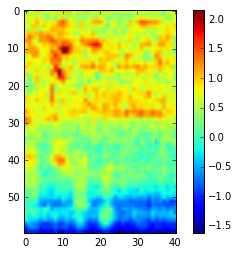

In [7]:
xx = data['val']['X'][20]
plt.imshow(xx[0] * (1.0 + np.random.randn() * 0.2) + np.random.randn() * 0.5)
plt.colorbar()

print data['train']['X'].shape

In [15]:
from lasagne.layers import InputLayer, DimshuffleLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.nonlinearities import softmax, very_leaky_rectify as vlr
import theano

net = {}

net['input'] = InputLayer((None, 2, 60, 41))

net['conv1_1'] = ConvLayer(net['input'], 80, (57, 6), nonlinearity=vlr)
net['pool1'] = PoolLayer(net['conv1_1'], pool_size=(4, 3), stride=(1, 3))
net['pool1'] = DropoutLayer(net['pool1'], p=0.5)
net['conv1_2'] = ConvLayer(net['pool1'], 80, (1, 3), nonlinearity=vlr)
net['pool2'] = PoolLayer(net['conv1_2'], pool_size=(1, 3), stride=(1, 1))

net['fc6'] = DenseLayer(net['pool2'], num_units=512, nonlinearity=vlr)
net['fc6'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6'], num_units=512, nonlinearity=vlr)
net['fc7'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7'], num_units=10, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

In [16]:
# setting up network
class MyTrainSplit(nolearn.lasagne.TrainSplit):
    # custom data split
    def __call__(self, data, Yb, net):
        return data['train']['X'], data['val']['X'], data['train']['y'], data['val']['y']

def augment(X):
    for idx in xrange(X.shape[0]):
        mult = (1.0 + np.random.randn() * 0.1)
        add = np.random.randn() * 0.2
        X[idx] *= mult
        X[idx] += add
        if np.random.rand() > 0.95:
            shift = np.random.randint(0, 224)
            X[idx, 0] = np.roll(X[idx, 0], shift, 1)
    return X
    
class MyBatch(nolearn.lasagne.BatchIterator):
    def transform(self, Xb, yb):
        return augment(Xb), yb

    def __iter__(self):
        bs = self.batch_size
        for batch_idxs in mbg.minibatch_idx_iterator(
                self.y, bs, randomise=1, balanced=1):

            Xb = self.X[batch_idxs]
            yb = self.y[batch_idxs]
            yield self.transform(Xb, yb)
    

network = nolearn.lasagne.NeuralNet(
    layers=net['prob'],
    max_epochs=300,
    update=lasagne.updates.nesterov_momentum,
    update_learning_rate=0.002,
    update_momentum=0.9, 
    verbose=1,
    train_split=MyTrainSplit(None),
    batch_iterator_train=MyBatch(batch_size=64)
)

network.initialize()

In [38]:
# training
# network.load_params_from('mel_fake_full_71%.pkl'),

network.fit(data, None)

     90       0.21426       2.74335      0.07810      0.64120  8.03s
     91       0.21255       2.60675      0.08154      0.68140  7.96s
     92       0.20915       2.65995      0.07863      0.63319  7.91s
     93       0.20999       2.74437      0.07652      0.64386  8.12s
     94       0.20799       2.66072      0.07817      0.64253  7.92s
     95       0.20386       2.70536      0.07535      0.63053  8.08s
     96       0.20535       2.64087      0.07776      0.68331  8.04s
     97       0.20485       2.57833      0.07945      0.64367  8.00s
     98       0.20289       2.50391      0.08103      0.64863  8.05s
     99       0.20065       2.66539      0.07528      0.64272  7.83s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f94bc1dc4d0>,
     batch_iterator_train=<__main__.MyBatch object at 0x7f944ccd6050>,
     check_input=True, custom_epoch_scores=None, custom_scores=None,
     layers=[<lasagne.layers.special.NonlinearityLayer object at 0x7f944ccccd90>],
     loss=None, max_epochs=300, more_params={},
     objective=<function objective at 0x7f94bc15eed8>,
     objective_loss_function=<function categorical_crossentropy at 0x7f94bcae6c08>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7f944cd26ea8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7f944cd26d88>],
     regression=False,
     train_split=<__main__.MyTrainSplit object at 0x7f944ccd6350>,
     update=<function nesterov_momentum at 0x7f94bcaf7410>,
     update_learning_rate=0.002, update_momentum=0.9,
     use_label_encoder=Fa

In [39]:
y_preds = network.predict_proba(data['val']['X'])
# for seg_idx in np.unique(data['val'])

all_filenames = []

for fold_id in splits['val']:
    idxs = np.where(np.array(all_data['fold'] == fold_id))[0]
    all_filenames += [all_data['filename'][xx] for xx in idxs]
    
idx_to_filename = {idx:fname for idx, fname in enumerate(all_filenames)}

In [40]:
filename_arrs = {}
filename_means = {}
filename_sums = {}

for idx, pred in enumerate(y_preds):

    fname = idx_to_filename[idx]

    if fname in filename_arrs:
        filename_arrs[fname].append(pred)
    else:
        filename_arrs[fname] = [pred]
    
for key in filename_arrs:
    filename_means[key] = np.max(np.atleast_2d(np.vstack(filename_arrs[key])), 0)

# now predictions
fname_to_preds = {fname: np.argmax(preds) for fname, preds in filename_means.iteritems()}

# now evaluate
gt = {fname:pred for fname, pred in zip(all_filenames, data['val']['y'])}

np.mean([fname_to_preds[fname] == gt[fname] for fname in gt])    

0.70843672456575679

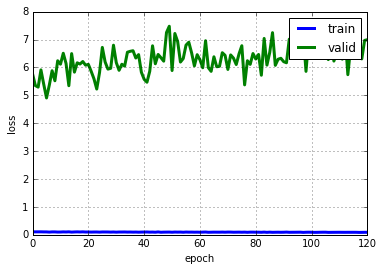

In [157]:
train_loss = np.array([i["train_loss"] for i in network.train_history_])
valid_loss = np.array([i["valid_loss"] for i in network.train_history_])
plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
# plt.ylim(1e-3, 1e-2)
# plt.yscale("log")
# plt.show()

In [75]:
# network.save_params_to('75%_acc_5463427b.pkl')
# network.save_params_to('mel_fake_70%.pkl')

from sklearn.metrics import confusion_matrix
from ml_helpers.evaluation import plot_confusion_matrix
mapper = dict(zip(data['train']['y'], data['train']['y_name']))
print mapper
cls_labels = [mapper[xx] for xx in range(10)]#[0, 4, 7]]
print cls_labels

y_pred = network.predict(data['val']['X'])

{0: 'air_conditioner', 1: 'car_horn', 2: 'children_playing', 3: 'dog_bark', 4: 'drilling', 5: 'engine_idling', 6: 'gun_shot', 7: 'jackhammer', 8: 'siren', 9: 'street_music'}
['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


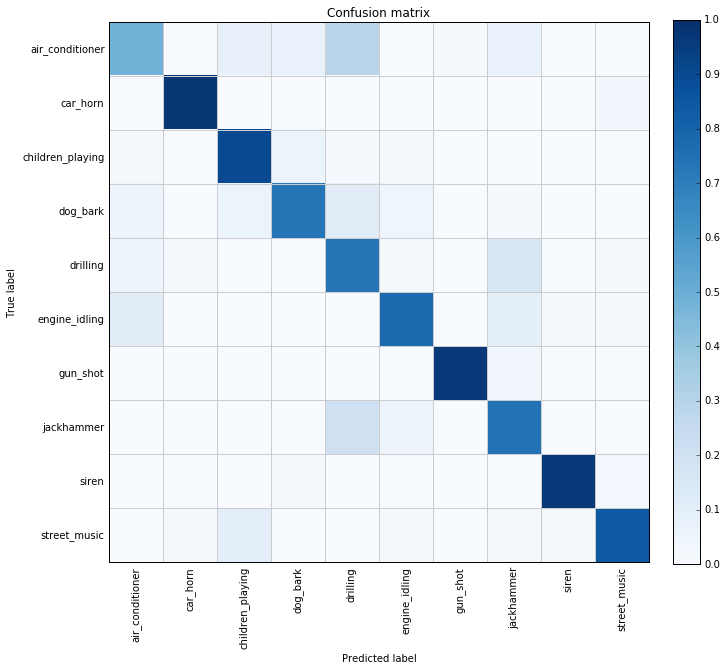

In [36]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(data['val']['y'], y_pred, normalise=1,
        cls_labels=cls_labels)